In [2]:
import numpy as np
import healpy as hp
import pymaster as nmt
import matplotlib.pyplot as plt
import itertools

%matplotlib inline

In [3]:
base_dir = '/scratch/gpfs/SIMONSOBS/users/ar3186/external_data/fgs_from_wmap_planck/'
beam_treatment = 'beam_corrected'
data_types = ['original', 'filtered']

map_types = [
    'wmap_f023', 'planck_f030', 'planck_f143', 'planck_f353'
]

In [4]:
mode = 'EE'
imode_cmb = 1 # position of the selected mode in the cmb file
lmax_plot = 600
colors = ['blue', 'orange', 'green']

# fiducial cmb
fiducial_cmb = '/scratch/gpfs/SIMONSOBS/users/ar3186/common/camb_spectra/cls_planck_TT_EE_BB_TE.fits'

# bins
binning_file = '/scratch/gpfs/SIMONSOBS/sat-iso/transfer_function/soopercool_inputs/binning_car_lmax2160_deltal15_large_first_bin.npz'
i_max_bin = 40  # kept only the first i_max_bin bins

binning_edges = np.load(binning_file)
bin_centers_int = np.array(binning_edges['bin_center'][:i_max_bin], dtype=int)  # NOTE: this is exact only if bin centers are all integer values

nmt_bins = nmt.NmtBin.from_edges(binning_edges["bin_low"][:i_max_bin], binning_edges["bin_high"][:i_max_bin] + 1)
lmax_bins = nmt_bins.get_ell_max(nmt_bins.get_n_bands() - 1)

cmb_cl = hp.read_cl(fiducial_cmb)[imode_cmb, :lmax_bins+1]
cmb_clb = nmt_bins.bin_cell(cmb_cl)

In [5]:
itertools.combinations_with_replacement(map_types, 2)

In [6]:
cls_all_original = []
cls_all_filtered = []
labels_all = []

for map_type_a, map_type_b in itertools.combinations_with_replacement(map_types, 2):
    
    map_type_a_filtered = map_type_a + '_filtered_SATp3_f090_south_science'
    map_type_b_filtered = map_type_b + '_filtered_SATp3_f090_south_science'
    
    path_cls_original = base_dir + f'original_data/soopercool_outputs/{beam_treatment}/cells/decoupled_cross_pcls_{map_type_a}_x_{map_type_b}.npz'
    path_cls_filtered = base_dir + f'filtered_data/soopercool_outputs/{beam_treatment}/cells/decoupled_cross_pcls_{map_type_a_filtered}_x_{map_type_b_filtered}.npz'
    # print(path_cls_original)

    cls_all_original.append(np.load(path_cls_original)[mode][:i_max_bin])
    cls_all_filtered.append(np.load(path_cls_filtered)[mode][:i_max_bin])
    labels_all.append(f'{map_type_a[-4:]} x {map_type_b[-4:]}')

    ell_bins = np.load(path_cls_original)['lb'][:i_max_bin]

In [7]:
labels_all

['f023 x f023',
 'f023 x f030',
 'f023 x f143',
 'f023 x f353',
 'f030 x f030',
 'f030 x f143',
 'f030 x f353',
 'f143 x f143',
 'f143 x f353',
 'f353 x f353']

In [8]:
# Calculate number of rows needed for triangular layout

def get_triangle_rows(n_items):
    n = 0
    while (n * (n + 1)) // 2 < n_items:
        n += 1
    return n

n_plots = len(cls_all_original)
n_rows = get_triangle_rows(n_plots)

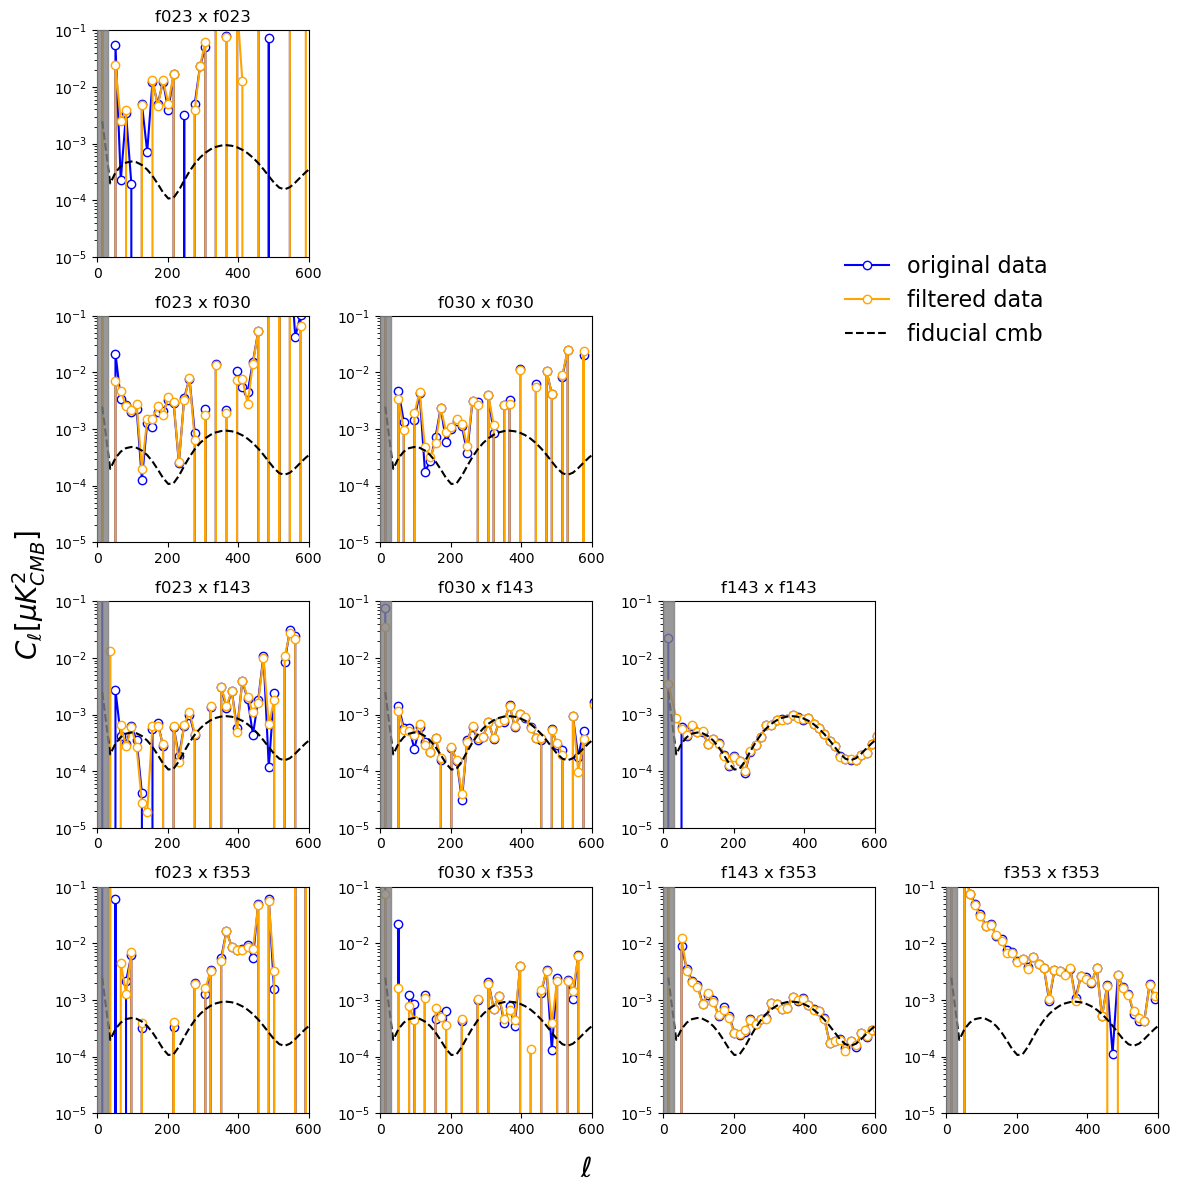

: 

In [ ]:
fig, axes = [], []

# Create subplots
fig_obj, axs = plt.subplots(n_rows, n_rows, figsize=(12, 12))

# Flatten axes and turn off unused ones
axs = np.array(axs)
axs = axs.reshape(n_rows, n_rows)

# Only use lower triangle
plot_idx = 0
for j in range(n_rows):
    for i in range(j, n_rows):
        if plot_idx < n_plots:
            ax = axs[i, j]
            ax.set_title(labels_all[plot_idx])
            ax.plot(ell_bins, cls_all_original[plot_idx], mfc="w", marker="o", c=colors[0], label='original data')
            ax.plot(ell_bins, cls_all_filtered[plot_idx], mfc="w", marker="o", c=colors[1], label='filtered data')
            ax.plot(ell_bins, cmb_clb, c="k", ls="--", label='fiducial cmb')

            ax.set_yscale('log')
            ax.set_xlim(0, 600) #lmax)
            ax.set_ylim(1e-5, 1e-1)

            ax.axvspan(0, 30, color='gray', alpha=0.8, zorder=10)

            plot_idx += 1
        else:
            axs[i, j].axis('off')

# Turn off upper triangle
for i in range(n_rows):
    for j in range(i + 1, n_rows):
        axs[i, j].axis('off')


fig_obj.supxlabel(r"$\ell$", fontsize=20)
fig_obj.supylabel(r"$C_{\ell} [\mu K_{CMB} ^2]$", fontsize=20)

plt.tight_layout()

handles, labels = axs[0, 0].get_legend_handles_labels()
fig_obj.legend(handles, labels, loc='upper center', ncol=1, fontsize=16, frameon=False, bbox_to_anchor=(0.8, 0.8))

fig_obj.savefig('cross_spectra_for_fgs_wmpa_planck.png', bbox_inches='tight', dpi=300)
plt.show()